<a href="https://colab.research.google.com/github/Kaia-nyoung/2025-ML-class/blob/main/6%EC%A3%BC%EC%B0%A8/CIFAR_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os

DATA_DIR= '/content/drive/MyDrive/ML-MK'

os.makedirs(DATA_DIR, exist_ok=True)

In [2]:
cifar10_path = os.path.join(DATA_DIR,'cifar-10-batches-py')

In [3]:
if os.path.exists(cifar10_path):
    print(f"✓ 기존 데이터 발견: {cifar10_path}")
    print("저장된 데이터를 로드합니다...")
else:
    print(f"데이터가 없습니다. {DATA_DIR}에 다운로드합니다...")

데이터가 없습니다. /content/drive/MyDrive/ML-MK에 다운로드합니다...


In [4]:
# 데이터 로드 (없으면 자동 다운로드 후 캐싱)
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"✓ 데이터 로드 완료")
print(f"  - 학습 데이터: {x_train.shape}")
print(f"  - 테스트 데이터: {x_test.shape}\n")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
✓ 데이터 로드 완료
  - 학습 데이터: (50000, 32, 32, 3)
  - 테스트 데이터: (10000, 32, 32, 3)



In [5]:
# 클래스 이름 정의
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [6]:
# 사용할 클래스 선택
selected_classes = ['cat','dog','horse']
selected_idx = [class_names.index(c)for c in selected_classes]

In [7]:
# --- 해당 클래스만 필터링 ---
train_mask = np.isin(y_train, selected_idx).flatten()
test_mask = np.isin(y_test, selected_idx).flatten()

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

print(f"선택된 클래스: {selected_classes}")
print(f"  - 학습 샘플 수: {len(x_train)}")
print(f"  - 테스트 샘플 수: {len(x_test)}\n")

선택된 클래스: ['cat', 'dog', 'horse']
  - 학습 샘플 수: 15000
  - 테스트 샘플 수: 3000



In [8]:
# 라벨을 0~2로 다시 매핑
label_map = {v: i for i, v in enumerate(selected_idx)}
y_train = np.array([label_map[int(y)]for y in y_train])
y_test = np.array([label_map[int(y)]for y in y_test])

/tmp/ipython-input-2451507799.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train = np.array([label_map[int(y)]for y in y_train])
/tmp/ipython-input-2451507799.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = np.array([label_map[int(y)]for y in y_test])


In [9]:
# 정규화
x_train, x_test = x_train / 255.0, x_test / 255.0

In [10]:
# === 1) 라벨 모양 정리 & 학습/검증 분리 ===
from sklearn.model_selection import train_test_split

y_train = y_train.flatten()
y_test  = y_test.flatten()

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(x_tr.shape, x_val.shape, x_test.shape)

(12000, 32, 32, 3) (3000, 32, 32, 3) (3000, 32, 32, 3)


In [11]:
# === 2) 간단 CNN 모델 정의 ===
from tensorflow.keras import layers, models, callbacks

num_classes = 3

model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # y가 0~2 정수
    metrics=['accuracy']
)

es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy')

history = model.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[es],
    verbose=1
)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.3908 - loss: 1.0656 - val_accuracy: 0.5553 - val_loss: 0.8868
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5472 - loss: 0.8902 - val_accuracy: 0.6080 - val_loss: 0.7918
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6056 - loss: 0.8109 - val_accuracy: 0.6517 - val_loss: 0.7616
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6352 - loss: 0.7614 - val_accuracy: 0.6727 - val_loss: 0.7261
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6742 - loss: 0.7163 - val_accuracy: 0.6920 - val_loss: 0.6820
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6918 - loss: 0.6803 - val_accuracy: 0.7127 - val_loss: 0.6368
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7192 - loss: 0.6346 - val_accuracy: 0.7163 - val_loss: 0.6330
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7366 - loss: 0.6078 - val_accuracy: 0.7290 - 

In [12]:
# === 3) 테스트 평가 ===
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.8167


In [13]:
# === 4) 예측/리포트/혼동행렬 ===
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_prob = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

inv_label_map = {v:k for k,v in {
    'cat':0, 'dog':1, 'horse':2
}.items()}  # 우리가 매핑한 0:cat,1:dog,2:horse 기준

target_names = ['cat','dog','horse']
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         cat     0.7923    0.7630    0.7774      1000
         dog     0.7544    0.8140    0.7831      1000
       horse     0.9113    0.8730    0.8917      1000

    accuracy                         0.8167      3000
   macro avg     0.8193    0.8167    0.8174      3000
weighted avg     0.8193    0.8167    0.8174      3000



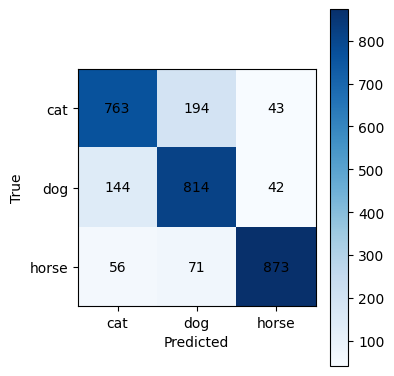

In [14]:
# 혼동행렬 시각화(간단한 matplotlib 표기)
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
ax.set_xticklabels(target_names); ax.set_yticklabels(target_names)
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.colorbar(im); plt.tight_layout(); plt.show()